# Credit Fraud

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Data Import

In [5]:
from zipfile import ZipFile
zip_file = ZipFile('/content/drive/MyDrive/CreditFraud.zip')

data = pd.read_csv(zip_file.open('creditcard.csv'))

In [6]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.count()

,0
Time,284807
V1,284807
V2,284807
V3,284807
V4,284807
V5,284807
V6,284807
V7,284807
V8,284807
V9,284807


## Balanceado

In [ ]:
data_class_1_balanceado = data[data['Class'] == 1]
data_class_0_balanceado = data[data['Class'] == 0]

#Deixamos 492 transações verdadeiras e 492 Falsas, equilibrando nossa base de teste em 50%
data_class_0_reduced_balanceado = data_class_0_balanceado.sample(n=492, random_state=1)

data_balanceado = pd.concat([data_class_1_balanceado, data_class_0_reduced_balanceado], ignore_index=True)

In [ ]:
data_balanceado.count()

,0
Time,984
V1,984
V2,984
V3,984
V4,984
V5,984
V6,984
V7,984
V8,984
V9,984


In [ ]:
data_balanceado.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
979,34090.0,1.384778,-0.613943,-0.473714,-1.080493,-0.134557,0.127233,-0.322239,-0.005842,-1.099339,...,-0.926508,-2.437317,0.107510,-1.453848,0.010721,0.602221,-0.085445,-0.006771,55.90,0
980,147272.0,-0.662865,-0.063548,-0.453997,0.365725,-0.053082,-1.877818,1.369474,-0.415603,0.164133,...,0.319064,1.076870,0.572212,0.805659,-0.418046,-0.197208,0.118548,0.085739,173.05,0
981,114733.0,-1.072320,-1.383812,1.110494,-3.057725,0.355135,-0.062749,-0.135126,-0.519193,-1.626258,...,-0.226405,0.265666,-0.437952,0.378339,-0.278275,-0.400838,-0.468408,-0.180677,88.00,0
982,122737.0,-0.580157,0.568520,2.000309,-0.551757,0.202593,0.304296,0.763987,-0.039123,0.280374,...,-0.218156,-0.535974,-0.167347,0.548246,0.296848,-0.467760,-0.107231,-0.141449,49.98,0
983,82548.0,0.766537,-0.650138,0.977318,1.154468,-0.388724,1.745749,-0.836021,0.724766,0.959928,...,0.161340,0.444720,0.045154,-0.996731,-0.014749,-0.277953,0.110193,0.039860,116.49,0


In [ ]:
print(f"{round(data_balanceado['Class'].value_counts()[1] / len(data_balanceado) * 100, 2)}% ou {len(data_balanceado.loc[data_balanceado['Class'] == 1])} transações são fraudulentas.")

50.0% ou 492 transações são fraudulentas.


### Distribution of data

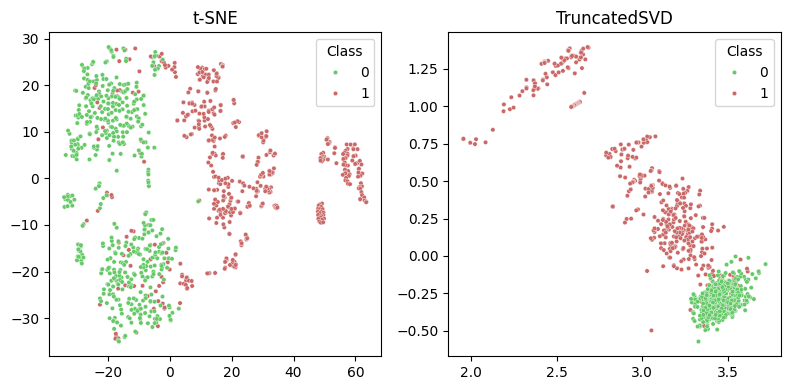

In [ ]:
colors = ['#66c968', '#C96866']

def decomp_plots(X_tsne, X_svd, hue=data_balanceado['Class']):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=hue, palette=colors, s=10)
    plt.title('t-SNE')

    plt.subplot(1, 3, 2)
    sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=hue, palette=colors, s=10)
    plt.title('TruncatedSVD')

    plt.tight_layout()
    plt.show()

X = data_balanceado.drop(['Class'], axis=1)
y = data_balanceado['Class']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(X_scaled)

svd = TruncatedSVD(n_components=2, random_state=RANDOM_SEED)
X_svd = svd.fit_transform(X_scaled)

decomp_plots(X_tsne, X_svd)

### Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((738, 30), (246, 30), (738,), (246,))

### Caso Base - Logistic Regression Classifier

In [ ]:
regressorL = LogisticRegression(max_iter=1000)
regressorL.fit(X_train, y_train)

y_regressor = regressorL.predict(X_test)

# replacing values in the resulting array
y_regressor = np.where(y_regressor == 1, 0, y_regressor)
y_regressor = np.where(y_regressor == -1, 1, y_regressor)

print(f'Anomalies are predicted: {sum(y_regressor)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_regressor)/len(data_balanceado), 6) * 100}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test)* 100, 4)}%')

print(classification_report(y_test, y_regressor))

Anomalies are predicted: 0
The proportion of predicted anomalies from the total number of transactions: 0.0%
Percentage of anomalies from the total number of transactions in the test sample: 50.0%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       123
           1       0.00      0.00      0.00       123

    accuracy                           0.50       246
   macro avg       0.25      0.50      0.33       246
weighted avg       0.25      0.50      0.33       246



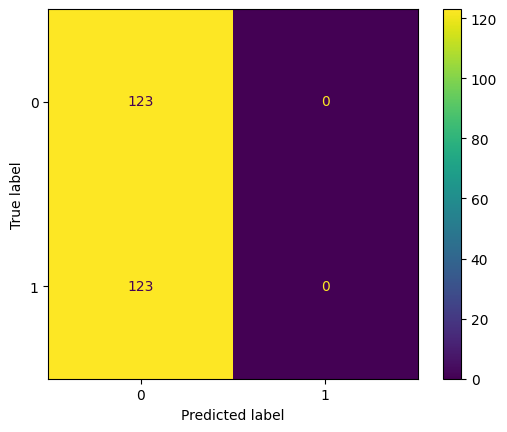

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_regressor)
plt.show()

In [ ]:
def compare_plot(y_pred):
    X_test_svd = svd.fit_transform(X_test)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_test_svd[:, 0], y=X_test_svd[:, 1], hue=y_pred, palette=colors, s=10)
    plt.title('Predicted data with TruncatedSVD')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=data_balanceado['Class'], palette=colors, s=10)
    plt.title('Original data with TruncatedSVD')

    plt.tight_layout()
    plt.show()

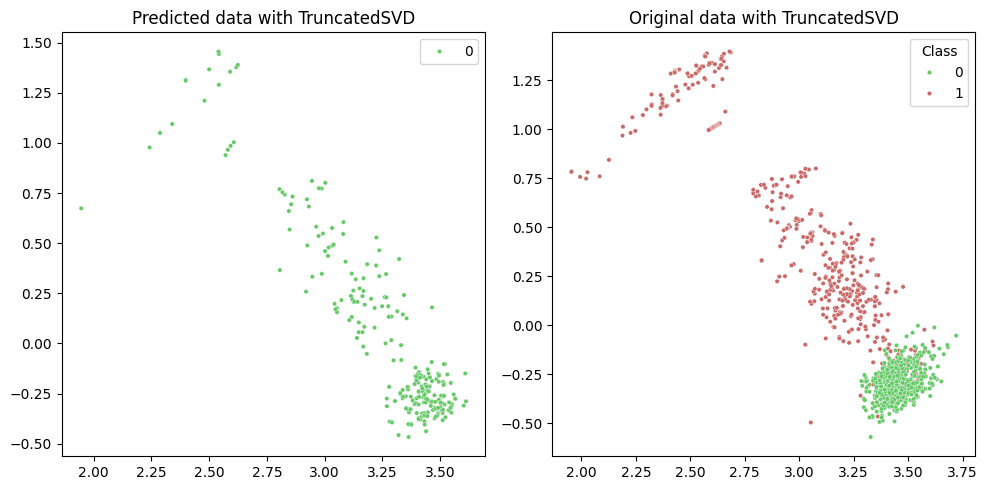

In [ ]:
compare_plot(y_regressor)

### Isolation Forest

In [ ]:
forest = IsolationForest(contamination=0.017, n_jobs=-1, random_state=RANDOM_SEED)
forest.fit(X_train)

y_forest = forest.predict(X_test)

# replacing values in the resulting array
y_forest = np.where(y_forest == 1, 0, y_forest)
y_forest = np.where(y_forest == -1, 1, y_forest)

print(f'Anomalies are predicted: {sum(y_forest)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_forest)/len(data_balanceado), 6) * 100}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test)* 100, 4)}%')

print(classification_report(y_test, y_forest))

Anomalies are predicted: 2
The proportion of predicted anomalies from the total number of transactions: 0.2033%
Percentage of anomalies from the total number of transactions in the test sample: 50.0%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       123
           1       1.00      0.02      0.03       123

    accuracy                           0.51       246
   macro avg       0.75      0.51      0.35       246
weighted avg       0.75      0.51      0.35       246



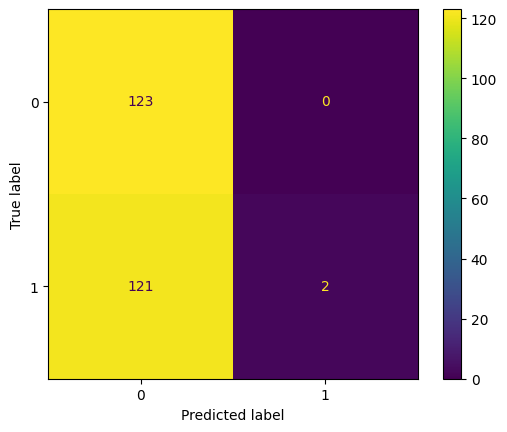

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_forest)
plt.show()

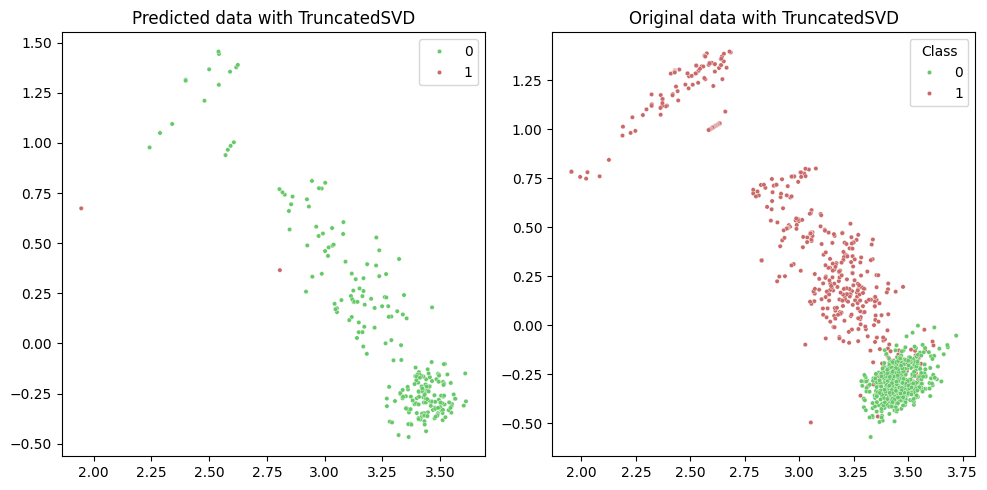

In [ ]:
compare_plot(y_forest)

### One-Class SVM

In [ ]:
svm = OneClassSVM(nu=0.017)
svm.fit(X_train)

y_svm = svm.predict(X_test)

# replacing values in the resulting array
y_svm = np.where(y_svm == 1, 0, y_svm)
y_svm = np.where(y_svm == -1, 1, y_svm)

In [ ]:
print(f'Anomalies are predicted: {sum(y_svm)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_svm)/len(data_balanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_svm))

Anomalies are predicted: 2
The proportion of predicted anomalies from the total number of transactions: 0.2033%
Percentage of anomalies from the total number of transactions in the test sample: 50.0%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       123
           1       1.00      0.02      0.03       123

    accuracy                           0.51       246
   macro avg       0.75      0.51      0.35       246
weighted avg       0.75      0.51      0.35       246



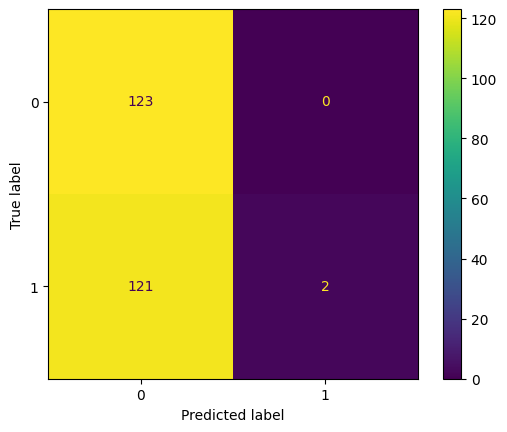

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_svm)
plt.show()

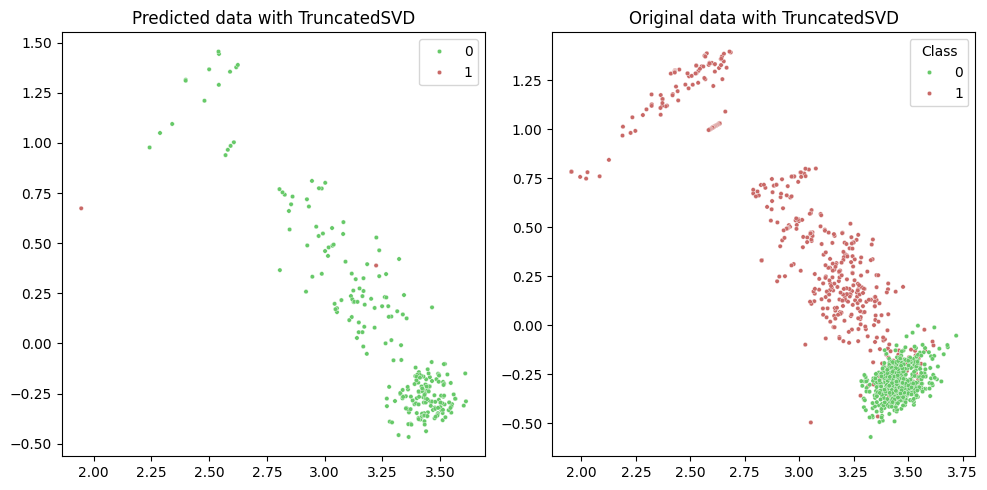

In [ ]:
compare_plot(y_svm)

### Local Outlier Factor

In [ ]:
lof = LocalOutlierFactor(contamination=0.017, n_jobs=-1)

y_lof = lof.fit_predict(X_test)

# replacing values in the resulting array
y_lof = np.where(y_lof == 1, 0, y_lof)
y_lof = np.where(y_lof == -1, 1, y_lof)

In [ ]:
print(f'Anomalies are predicted: {sum(y_lof)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_lof)/len(data_balanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_lof))

Anomalies are predicted: 5
The proportion of predicted anomalies from the total number of transactions: 0.5081%
Percentage of anomalies from the total number of transactions in the test sample: 50.0%
              precision    recall  f1-score   support

           0       0.51      0.99      0.67       123
           1       0.80      0.03      0.06       123

    accuracy                           0.51       246
   macro avg       0.65      0.51      0.37       246
weighted avg       0.65      0.51      0.37       246



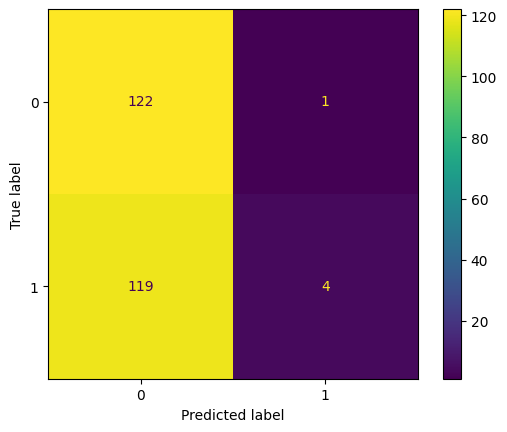

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_lof)
plt.show()

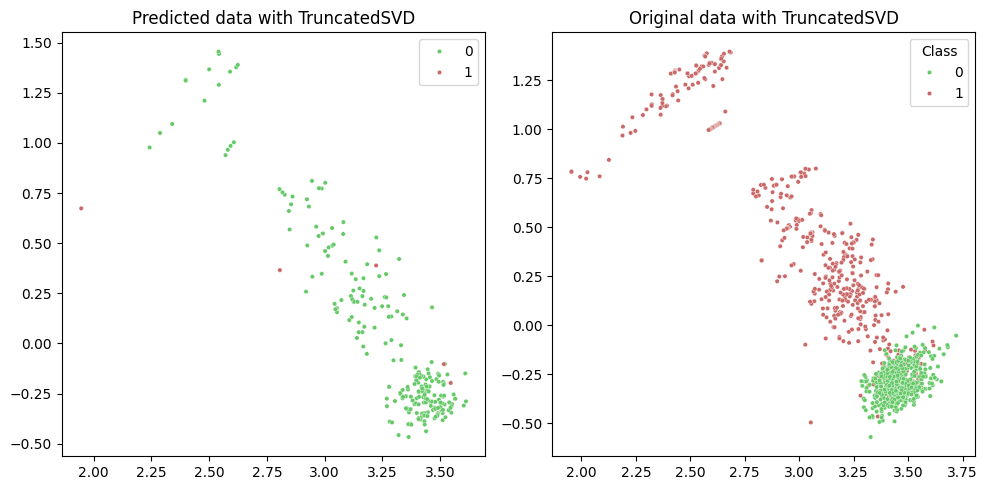

In [ ]:
compare_plot(y_lof)

### DBSCAN

In [ ]:
outlier_percentage = 1.0
eps = 0.05
while outlier_percentage > 0.17:
    dbscan = DBSCAN(eps=eps).fit(X_test)
    labels = dbscan.labels_
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = np.sum(labels == 1) / len(labels)
    eps += 0.05

dbscan = DBSCAN(eps)
dbscan.fit(X_test)
y_dbscan = np.array([1 if label == -1 else 0 for label in dbscan.labels_])

In [ ]:
print(f'Anomalies are predicted: {sum(y_dbscan)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_dbscan)/len(data_balanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_dbscan))

Anomalies are predicted: 27
The proportion of predicted anomalies from the total number of transactions: 2.7439%
Percentage of anomalies from the total number of transactions in the test sample: 50.0%
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       123
           1       0.96      0.21      0.35       123

    accuracy                           0.60       246
   macro avg       0.76      0.60      0.53       246
weighted avg       0.76      0.60      0.53       246



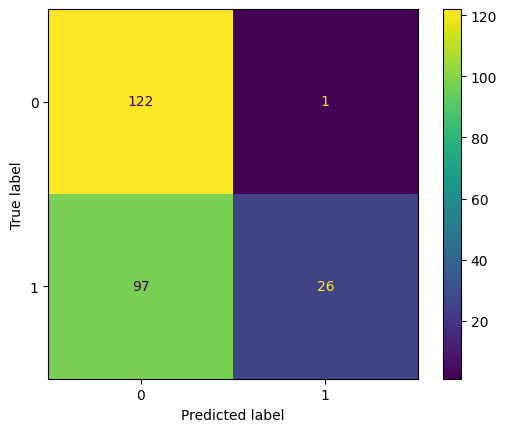

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_dbscan)
plt.show()

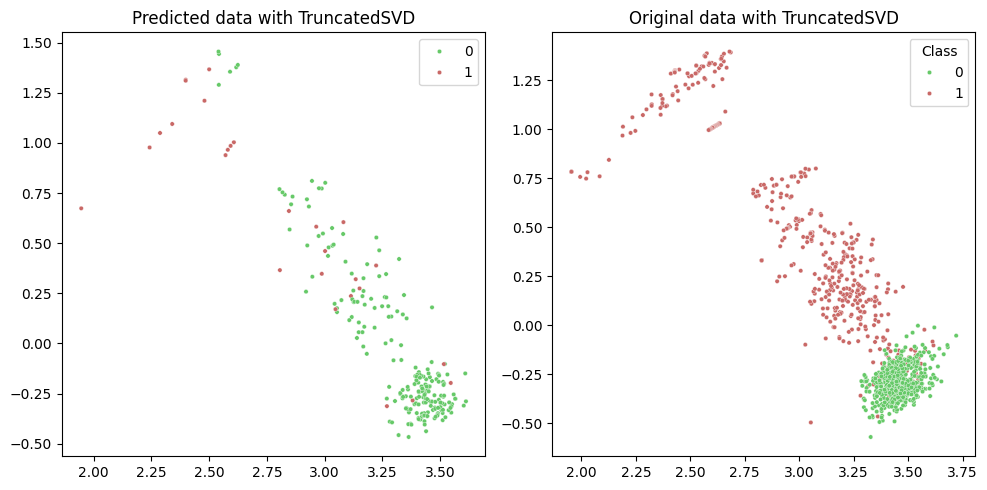

In [ ]:
compare_plot(y_dbscan)

### XGBoost

In [ ]:
# Instanciar o classificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Para problemas de classificação binária
    eval_metric='logloss',  # Métrica para avaliação
    use_label_encoder=False,  # Deprecado, definir como False
    random_state=42
)

model.fit(X_train, y_train)

y_xgboost = model.predict(X_test)

# replacing values in the resulting array
y_xgboost = np.where(y_xgboost == 1, 0, y_xgboost)
y_xgboost = np.where(y_xgboost == -1, 1, y_xgboost)


In [ ]:
print(f'Anomalies are predicted: {sum(y_xgboost)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_xgboost)/len(data_balanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_xgboost)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_xgboost))

Anomalies are predicted: 0
The proportion of predicted anomalies from the total number of transactions: 0.0%
Percentage of anomalies from the total number of transactions in the test sample: 0.0%
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       123
           1       0.00      0.00      0.00       123

    accuracy                           0.50       246
   macro avg       0.25      0.50      0.33       246
weighted avg       0.25      0.50      0.33       246



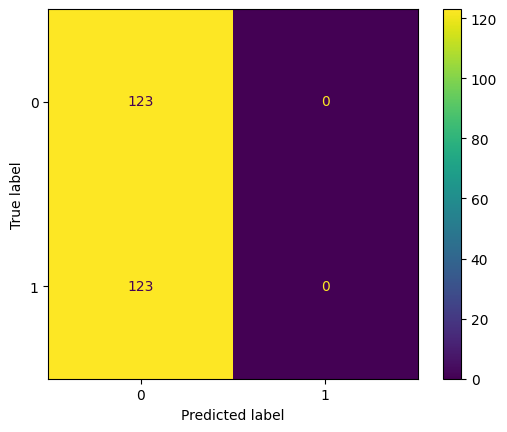

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_xgboost)
plt.show()

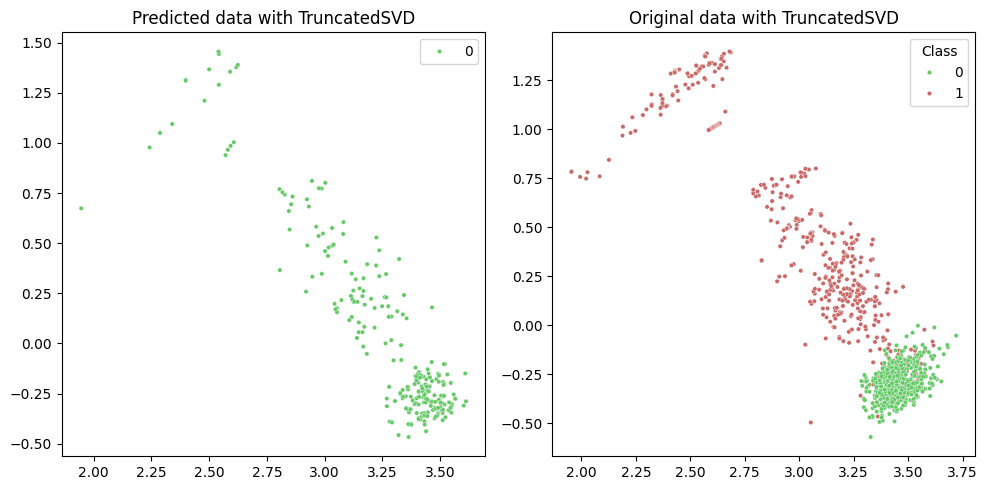

In [ ]:
compare_plot(y_xgboost)

Assim podemos identificar que o DBScan foi a melhor

## Desbalanceado

In [ ]:
data_class_1_desbalanceado = data[data['Class'] == 1]
data_class_0_desbalanceado = data[data['Class'] == 0]

percent_to_keep = 0.05  # Manter 10%, ou seja, reduzir em 90%
data_class_0_reduced_desbalanceado = data_class_0_desbalanceado.sample(frac=percent_to_keep, random_state=1)

data_desbalanceado = pd.concat([data_class_1_desbalanceado, data_class_0_reduced_desbalanceado], ignore_index=True)

In [ ]:
data_desbalanceado.count()

,0
Time,14708
V1,14708
V2,14708
V3,14708
V4,14708
V5,14708
V6,14708
V7,14708
V8,14708
V9,14708


In [ ]:
data_desbalanceado.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
14703,42071.0,1.284157,-0.910685,0.654187,-0.927862,-1.019708,0.452567,-1.231988,0.298191,-0.511947,...,0.423907,1.085877,-0.185527,-0.630257,0.382709,0.004648,0.039620,0.008595,39.00,0
14704,33303.0,1.425202,-1.167404,0.192354,-1.549624,-1.212251,-0.103159,-1.095554,0.092772,-1.978752,...,-0.154573,-0.151385,0.001151,-0.346096,0.306193,-0.166904,0.028112,0.003898,32.00,0
14705,54747.0,-0.921512,0.907032,0.289546,-1.204528,0.993935,-0.005322,0.932094,0.129613,-0.403636,...,-0.026950,-0.074529,-0.267323,-1.277494,0.120256,0.476659,-0.374906,-0.214285,32.67,0
14706,36714.0,1.233231,0.107071,0.251467,1.093559,0.129778,0.556558,-0.192972,0.131512,0.290480,...,-0.101927,-0.047213,-0.261886,-0.796089,0.845254,-0.245327,0.038219,0.001933,5.00,0
14707,124545.0,-0.785373,0.751188,1.666396,1.886982,2.076897,2.695826,0.370314,0.642897,-1.382583,...,0.430997,1.351417,-0.338091,-0.955964,-0.051709,0.146095,-0.028101,-0.099094,15.73,0


In [ ]:
print(f"{round(data_desbalanceado['Class'].value_counts()[1] / len(data_desbalanceado) * 100, 2)}% ou {len(data_desbalanceado.loc[data_desbalanceado['Class'] == 1])} transações são fraudulentas.")

3.35% ou 492 transações são fraudulentas.


### Distribution of data

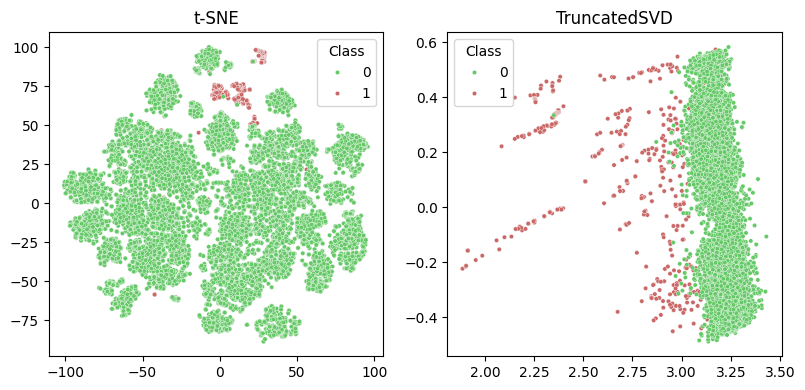

In [ ]:
colors = ['#66c968', '#C96866']

def decomp_plots(X_tsne, X_svd, hue=data_desbalanceado['Class']):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=hue, palette=colors, s=10)
    plt.title('t-SNE')

    plt.subplot(1, 3, 2)
    sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=hue, palette=colors, s=10)
    plt.title('TruncatedSVD')

    plt.tight_layout()
    plt.show()

X = data_desbalanceado.drop(['Class'], axis=1)
y = data_desbalanceado['Class']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(X_scaled)

svd = TruncatedSVD(n_components=2, random_state=RANDOM_SEED)
X_svd = svd.fit_transform(X_scaled)

decomp_plots(X_tsne, X_svd)

### Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11031, 30), (3677, 30), (11031,), (3677,))

### Caso Base - Logistic Regression Classifier

In [ ]:
regressorL = LogisticRegression(max_iter=1000)
regressorL.fit(X_train, y_train)

y_regressor = regressorL.predict(X_test)

# replacing values in the resulting array
y_regressor = np.where(y_regressor == 1, 0, y_regressor)
y_regressor = np.where(y_regressor == -1, 1, y_regressor)

print(f'Anomalies are predicted: {sum(y_regressor)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_regressor)/len(data_desbalanceado), 6) * 100}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test)* 100, 4)}%')

print(classification_report(y_test, y_regressor))

Anomalies are predicted: 0
The proportion of predicted anomalies from the total number of transactions: 0.0%
Percentage of anomalies from the total number of transactions in the test sample: 3.3451%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3554
           1       0.00      0.00      0.00       123

    accuracy                           0.97      3677
   macro avg       0.48      0.50      0.49      3677
weighted avg       0.93      0.97      0.95      3677



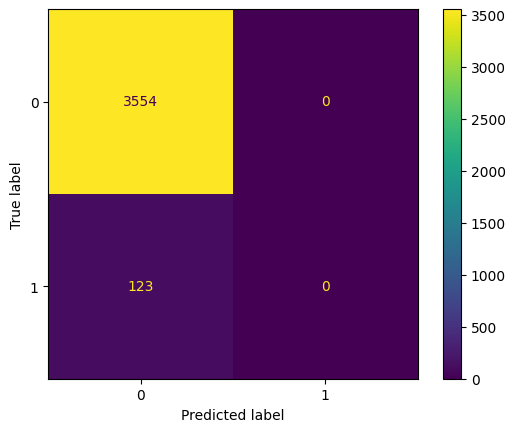

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_regressor)
plt.show()

In [ ]:
def compare_plot(y_pred):
    X_test_svd = svd.fit_transform(X_test)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_test_svd[:, 0], y=X_test_svd[:, 1], hue=y_pred, palette=colors, s=10)
    plt.title('Predicted data with TruncatedSVD')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=data_desbalanceado['Class'], palette=colors, s=10)
    plt.title('Original data with TruncatedSVD')

    plt.tight_layout()
    plt.show()

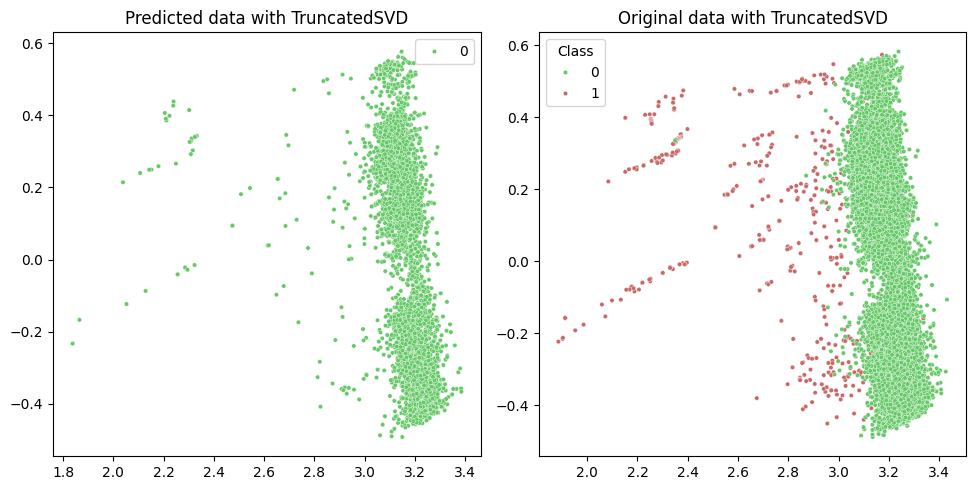

In [ ]:
compare_plot(y_regressor)

### Isolation Forest

In [ ]:
forest = IsolationForest(contamination=0.017, n_jobs=-1, random_state=RANDOM_SEED)
forest.fit(X_train)

y_forest = forest.predict(X_test)

# replacing values in the resulting array
y_forest = np.where(y_forest == 1, 0, y_forest)
y_forest = np.where(y_forest == -1, 1, y_forest)

print(f'Anomalies are predicted: {sum(y_forest)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_forest)/len(data_desbalanceado), 6) * 100}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test)* 100, 4)}%')

print(classification_report(y_test, y_forest))

Anomalies are predicted: 67
The proportion of predicted anomalies from the total number of transactions: 0.4555%
Percentage of anomalies from the total number of transactions in the test sample: 3.3451%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3554
           1       0.85      0.46      0.60       123

    accuracy                           0.98      3677
   macro avg       0.92      0.73      0.79      3677
weighted avg       0.98      0.98      0.98      3677



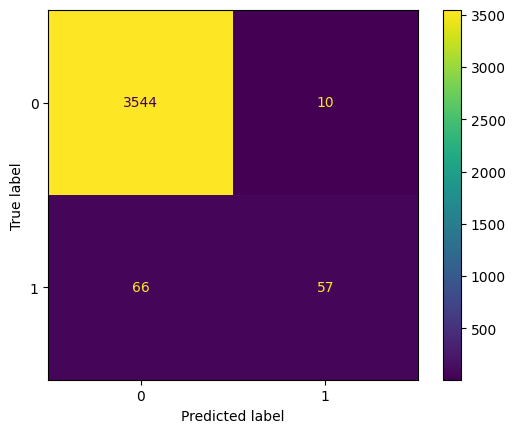

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_forest)
plt.show()

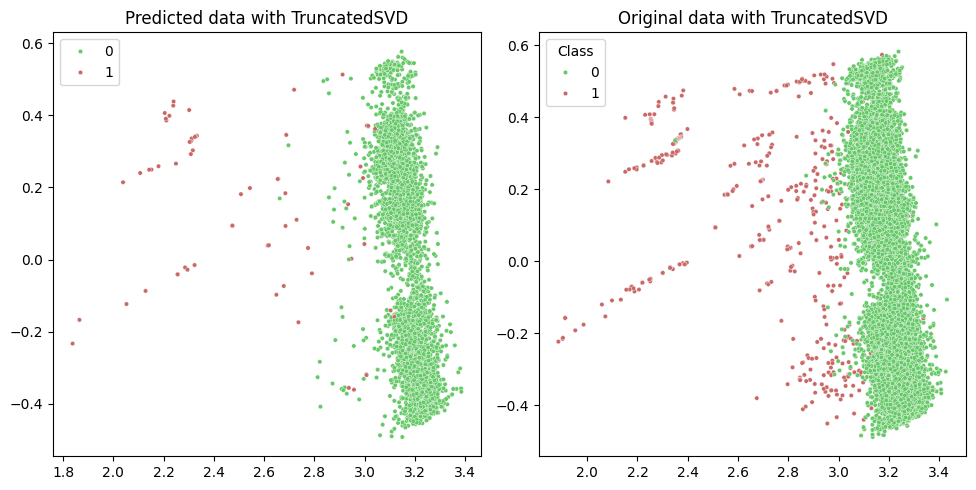

In [ ]:
compare_plot(y_forest)

### One-Class SVM

In [ ]:
svm = OneClassSVM(nu=0.017)
svm.fit(X_train)

y_svm = svm.predict(X_test)

# replacing values in the resulting array
y_svm = np.where(y_svm == 1, 0, y_svm)
y_svm = np.where(y_svm == -1, 1, y_svm)

In [ ]:
print(f'Anomalies are predicted: {sum(y_svm)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_svm)/len(data_desbalanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_svm))

Anomalies are predicted: 59
The proportion of predicted anomalies from the total number of transactions: 0.4011%
Percentage of anomalies from the total number of transactions in the test sample: 3.3451%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3554
           1       0.68      0.33      0.44       123

    accuracy                           0.97      3677
   macro avg       0.83      0.66      0.71      3677
weighted avg       0.97      0.97      0.97      3677



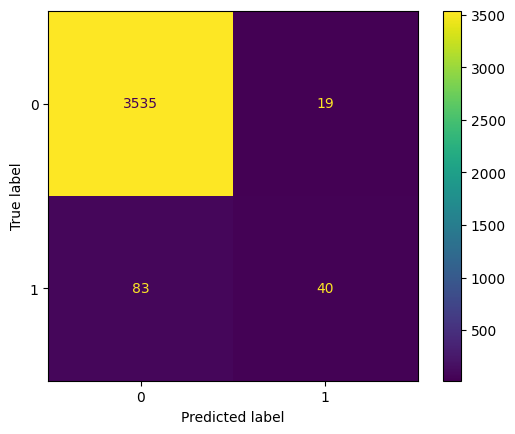

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_svm)
plt.show()

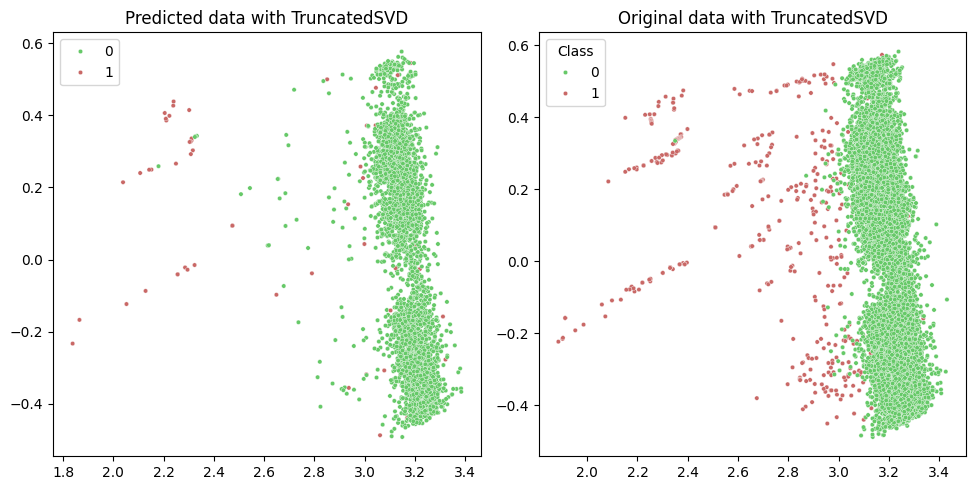

In [ ]:
compare_plot(y_svm)

### Local Outlier Factor

In [ ]:
lof = LocalOutlierFactor(contamination=0.017, n_jobs=-1)

y_lof = lof.fit_predict(X_test)

# replacing values in the resulting array
y_lof = np.where(y_lof == 1, 0, y_lof)
y_lof = np.where(y_lof == -1, 1, y_lof)

In [ ]:
print(f'Anomalies are predicted: {sum(y_lof)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_lof)/len(data_desbalanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_lof))

Anomalies are predicted: 63
The proportion of predicted anomalies from the total number of transactions: 0.4283%
Percentage of anomalies from the total number of transactions in the test sample: 3.3451%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3554
           1       0.27      0.14      0.18       123

    accuracy                           0.96      3677
   macro avg       0.62      0.56      0.58      3677
weighted avg       0.95      0.96      0.95      3677



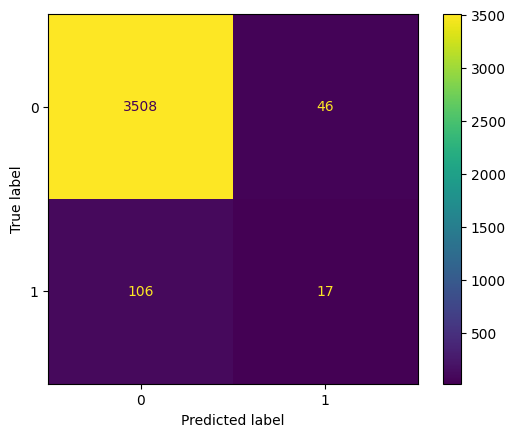

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_lof)
plt.show()

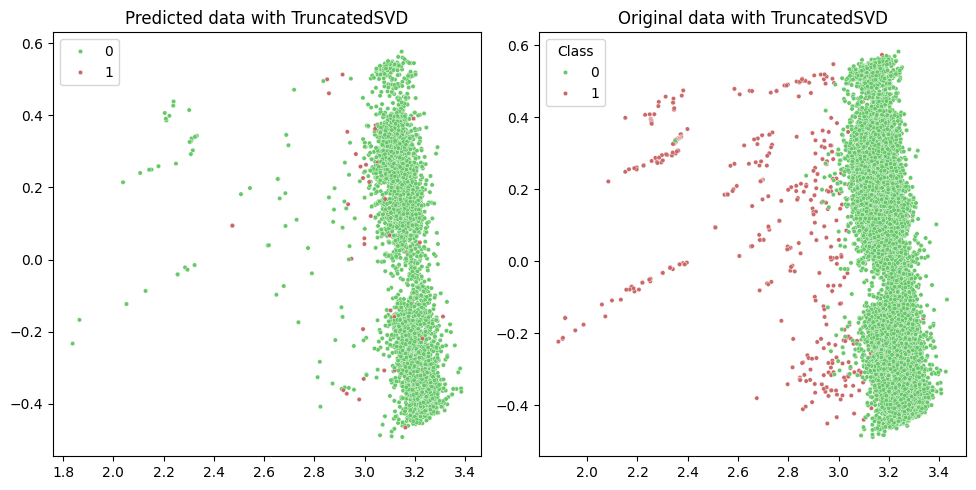

In [ ]:
compare_plot(y_lof)

### DBSCAN

In [ ]:
outlier_percentage = 1.0
eps = 0.05
while outlier_percentage > 0.17:
    dbscan = DBSCAN(eps=eps).fit(X_test)
    labels = dbscan.labels_
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = np.sum(labels == 1) / len(labels)
    eps += 0.05

dbscan = DBSCAN(eps)
dbscan.fit(X_test)
y_dbscan = np.array([1 if label == -1 else 0 for label in dbscan.labels_])

In [ ]:
print(f'Anomalies are predicted: {sum(y_dbscan)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_dbscan)/len(data_desbalanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_test)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_dbscan))

Anomalies are predicted: 216
The proportion of predicted anomalies from the total number of transactions: 1.4686%
Percentage of anomalies from the total number of transactions in the test sample: 3.3451%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3554
           1       0.43      0.75      0.54       123

    accuracy                           0.96      3677
   macro avg       0.71      0.86      0.76      3677
weighted avg       0.97      0.96      0.96      3677



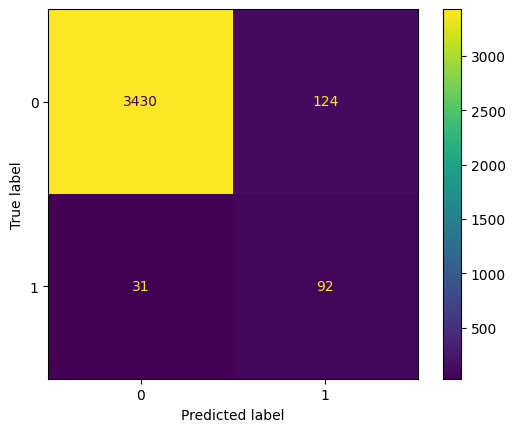

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_dbscan)
plt.show()

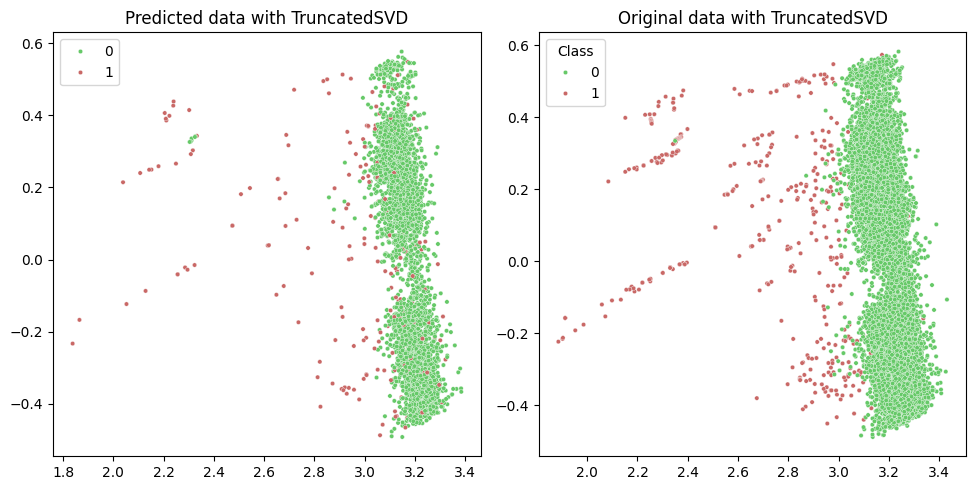

In [ ]:
compare_plot(y_dbscan)

### XGBoost

In [ ]:
# Instanciar o classificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Para problemas de classificação binária
    eval_metric='logloss',  # Métrica para avaliação
    use_label_encoder=False,  # Deprecado, definir como False
    random_state=42
)

model.fit(X_train, y_train)

y_xgboost = model.predict(X_test)

# replacing values in the resulting array
y_xgboost = np.where(y_xgboost == 1, 0, y_xgboost)
y_xgboost = np.where(y_xgboost == -1, 1, y_xgboost)


In [ ]:
print(f'Anomalies are predicted: {sum(y_xgboost)}')
print(f'The proportion of predicted anomalies from the total number of transactions: {round(sum(y_xgboost)/len(data_desbalanceado) * 100, 4)}%')
print(f'Percentage of anomalies from the total number of transactions in the test sample: {round(sum(y_xgboost)/len(X_test) * 100, 4)}%')

print(classification_report(y_test, y_xgboost))

Anomalies are predicted: 0
The proportion of predicted anomalies from the total number of transactions: 0.0%
Percentage of anomalies from the total number of transactions in the test sample: 0.0%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3554
           1       0.00      0.00      0.00       123

    accuracy                           0.97      3677
   macro avg       0.48      0.50      0.49      3677
weighted avg       0.93      0.97      0.95      3677



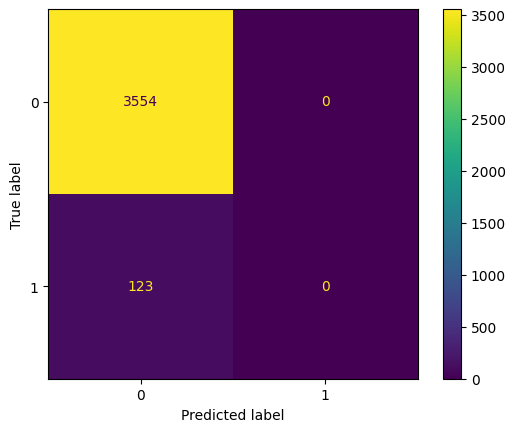

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_xgboost)
plt.show()

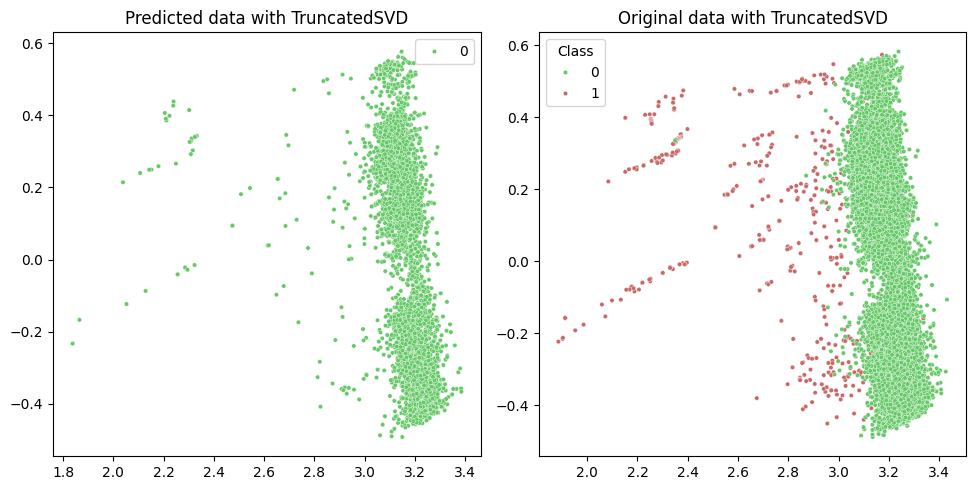

In [ ]:
compare_plot(y_xgboost)

Assim podemos identificar que o DBScan foi a melhor